In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, peak_widths

# File path and name
file_path = '/Users/muntasirmahmud/Library/CloudStorage/OneDrive-UMBC/4. SciGlob/Panndora_456/Lab_pandora/25_Apr 25_pandora157/Pandora157s1_GreenbeltMD_20250330_L0.txt'

base_name = os.path.basename(file_path)

# Read the entire file
with open(file_path, 'r', encoding='latin1') as file:
    lines = file.readlines()

# Skip the initial 89 rows
data_lines = lines[44:]

# Process each line to split into rows and columns
data_list = []
for line in data_lines:
    # Strip the newline character and split by tabs
    rows = line.strip().split('\t')
    for row in rows:
        # Split each row by spaces
        columns = row.split()
        data_list.append(columns)

# Convert the list of lists into a DataFrame
data1 = pd.DataFrame(data_list)

# Convert the necessary columns to numeric before saving
data1.iloc[:, 2:4127] = data1.iloc[:, 2:4127].apply(pd.to_numeric, errors='coerce')


In [129]:
print(ss_l0.shape)
print(SQ_dc_full.shape)

(75, 2048)
(75, 4130)


In [23]:
# Define the conditions
conditions = {
    "SQ_bc": (data1[0] == "SQ") & (data1[8] == 1) & (data1[9] == 7),
    "SQ_dc": (data1[0] == "SQ") & (data1[8] == 1) & (data1[9] == 3)
}

# Full filtered DataFrame with metadata (including time)
SQ_bc_full = data1.loc[conditions["SQ_bc"]].reset_index(drop=True)
SQ_dc_full = data1.loc[conditions["SQ_dc"]].reset_index(drop=True)

scale_factor_bc = SQ_bc_full.iloc[:, 22].astype(float).values
scale_factor_dc = SQ_dc_full.iloc[:, 22].astype(float).values

SQ_bc = SQ_bc_full.iloc[:, 24:2072].astype(float).values / scale_factor_bc[:, np.newaxis]
SQ_dc = SQ_dc_full.iloc[:, 24:2072].astype(float).values / scale_factor_dc[:, np.newaxis]

# ss_l0 = SQ_bc - SQ_dc

ValueError: operands could not be broadcast together with shapes (291,2048) (75,2048) 

(75, 2048)
(75, 2048)


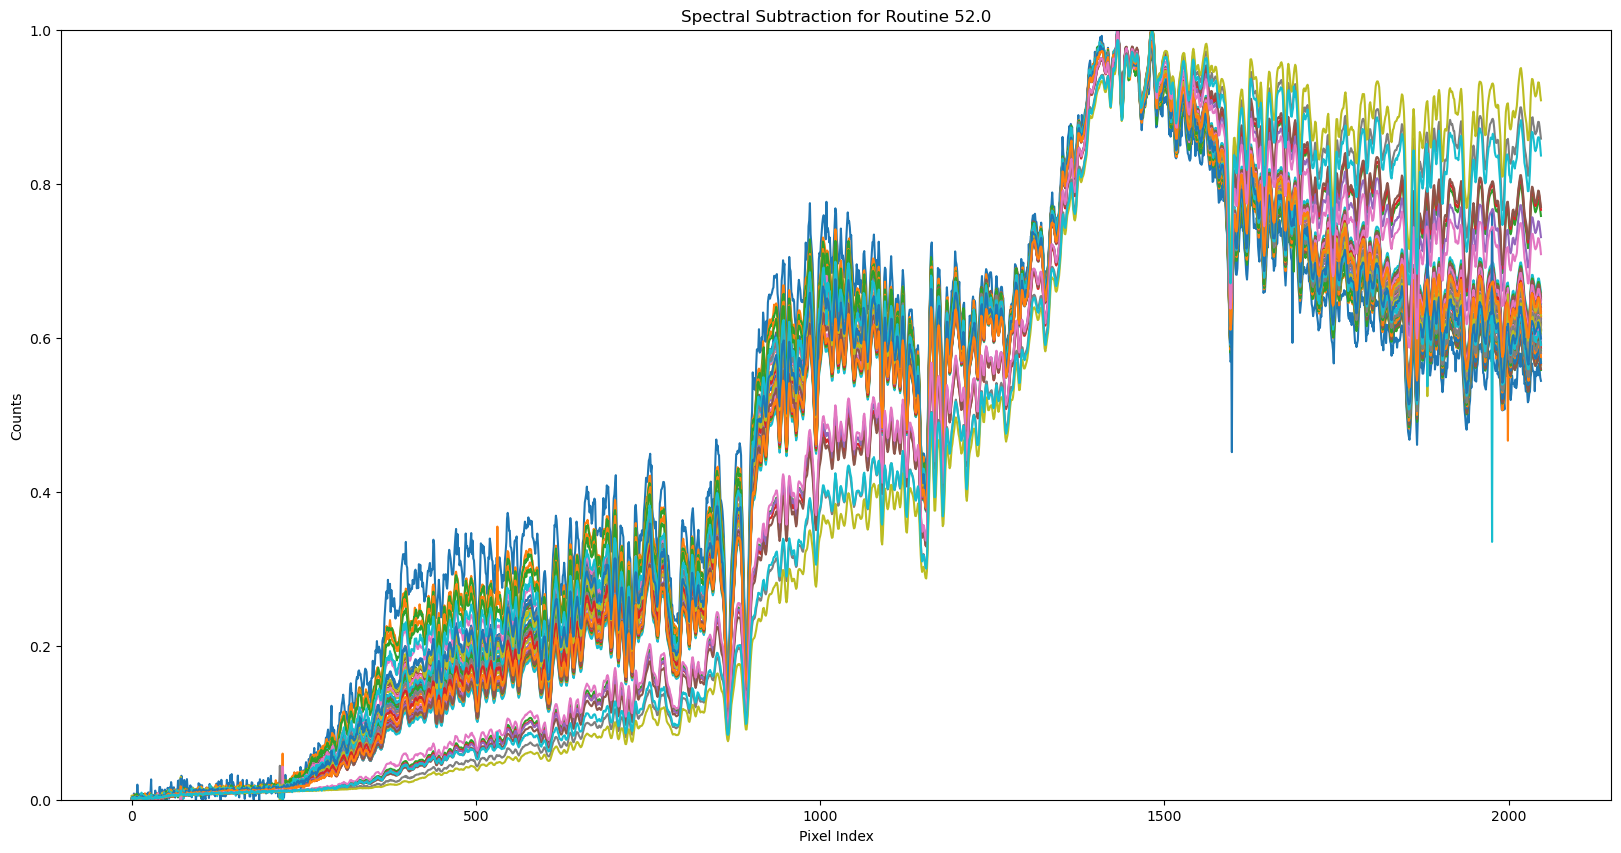

In [295]:
# Convert column 2 (Routine Count) to numeric for grouping
data1[2] = pd.to_numeric(data1[2], errors='coerce')

# Define conditions for bright and dark counts
is_SQ = data1[0] == "SQ"
is_bc = (data1[8] == 1) & (data1[9] == 7)
is_dc = (data1[8] == 1) & (data1[9] == 3)

# Filter bright and dark rows
SQ_bc_full = data1[is_SQ & is_bc].copy()
SQ_dc_full = data1[is_SQ & is_dc].copy()

# Convert routine count and scale factor
SQ_bc_full['routine'] = SQ_bc_full[2].astype(float)
SQ_dc_full['routine'] = SQ_dc_full[2].astype(float)
SQ_bc_full['scale'] = SQ_bc_full[22].astype(float)
SQ_dc_full['scale'] = SQ_dc_full[22].astype(float)

# Prepare arrays to collect processed spectra
matched_sq = []
routine_ids = []

# Group bright counts by routine number
grouped_bc = SQ_bc_full.groupby('routine')
grouped_dc = SQ_dc_full.set_index('routine')

for routine, group in grouped_bc:
    if routine in grouped_dc.index:
        # Get corresponding dark count row
        dark_row = grouped_dc.loc[routine]
        
        # If multiple dark rows exist for this routine, use the first one
        if isinstance(dark_row, pd.DataFrame):
            dark_row = dark_row.iloc[0]
        
        # Average bright rows (if more than one)
        bc_scaled = group.iloc[:, 24:2072].astype(float).div(group['scale'], axis=0)
        bc_mean = bc_scaled.mean(axis=0)

        # Scale dark count
        dc_scaled = dark_row.iloc[24:2072].astype(float) / dark_row['scale']

        # Subtract and store
        sq = bc_mean.values - dc_scaled.values
        matched_sq.append(sq)
        routine_ids.append(routine)

# Convert to array and DataFrame
sq_l0 = np.array(matched_sq)
print(sq_l0.shape)

for i in range(len(sq_l0)):
    sq_l0[i] = sq_l0[i]/ max(sq_l0[i])
sq_l0_df = pd.DataFrame(sq_l0, index=routine_ids)
print(sq_l0.shape)

plt.figure(figsize=(20, 10))
for i in range(10,70):
    plt.plot(sq_l0[i])
plt.title(f"Spectral Subtraction for Routine {routine_ids[0]}")
plt.xlabel("Pixel Index")
plt.ylabel("Counts")
plt.ylim(0, 1)
# plt.xlim(1550,1650)
plt.show()


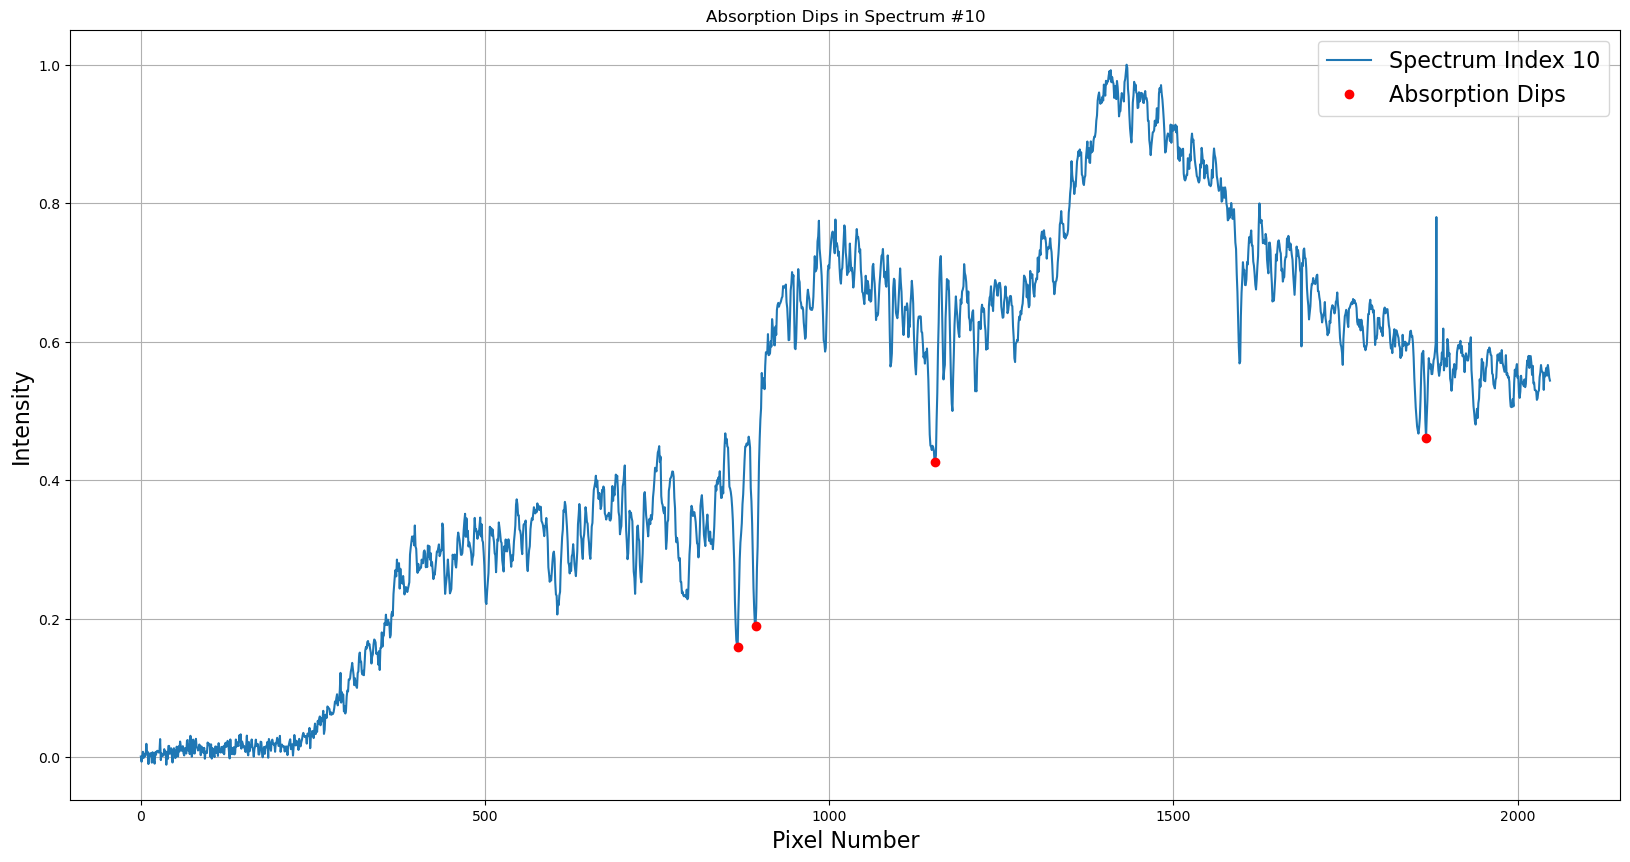

In [169]:
from scipy.signal import find_peaks, peak_widths
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

num_spectra, num_pixels = ss_l0.shape

# Store dips info
dip_positions = []  # pixel positions of dips
dip_widths = []     # FWHM values
dip_depths = []     # depths (intensity values) of dips

# Index of spectrum to visualize (change this later as needed)
spectrum_index_to_plot = 10

for i in range(num_spectra):
    spectrum = ss_l0[i]
    
    # Invert for dip detection
    inverted = -spectrum

    # Find dips (negative peaks)
    peaks, properties = find_peaks(inverted, prominence=0.25, distance=5)
    results_half = peak_widths(inverted, peaks, rel_height=0.5)

    # Store data
    dip_positions.append(peaks)
    dip_widths.append(results_half[0])  # width in pixels
    dip_depths.append(spectrum[peaks])  # actual (negative) dip values

    # Plot only the selected spectrum
    if i == spectrum_index_to_plot:
        plt.figure(figsize=(20, 10))
        plt.plot(spectrum, label=f'Spectrum Index {i}')
        plt.plot(peaks, spectrum[peaks], 'ro', label='Absorption Dips')
        plt.title(f'Absorption Dips in Spectrum #{i}')
        plt.xlabel("Pixel Number", fontsize=16)
        plt.ylabel("Intensity", fontsize=16)
        plt.legend(fontsize=16)
        # plt.xlim(500,1000)
        plt.grid(True)
        plt.show()

# Create DataFrames for analysis across all spectra
max_dips = max(len(p) for p in dip_positions)


dip_pixel_df = pd.DataFrame([
    np.pad(np.array(p, dtype=float), (0, max_dips - len(p)), constant_values=np.nan) 
    for p in dip_positions
])

dip_width_df = pd.DataFrame([
    np.pad(np.array(w, dtype=float), (0, max_dips - len(w)), constant_values=np.nan) 
    for w in dip_widths
])

dip_depth_df = pd.DataFrame([
    np.pad(np.array(d, dtype=float), (0, max_dips - len(d)), constant_values=np.nan) 
    for d in dip_depths
])



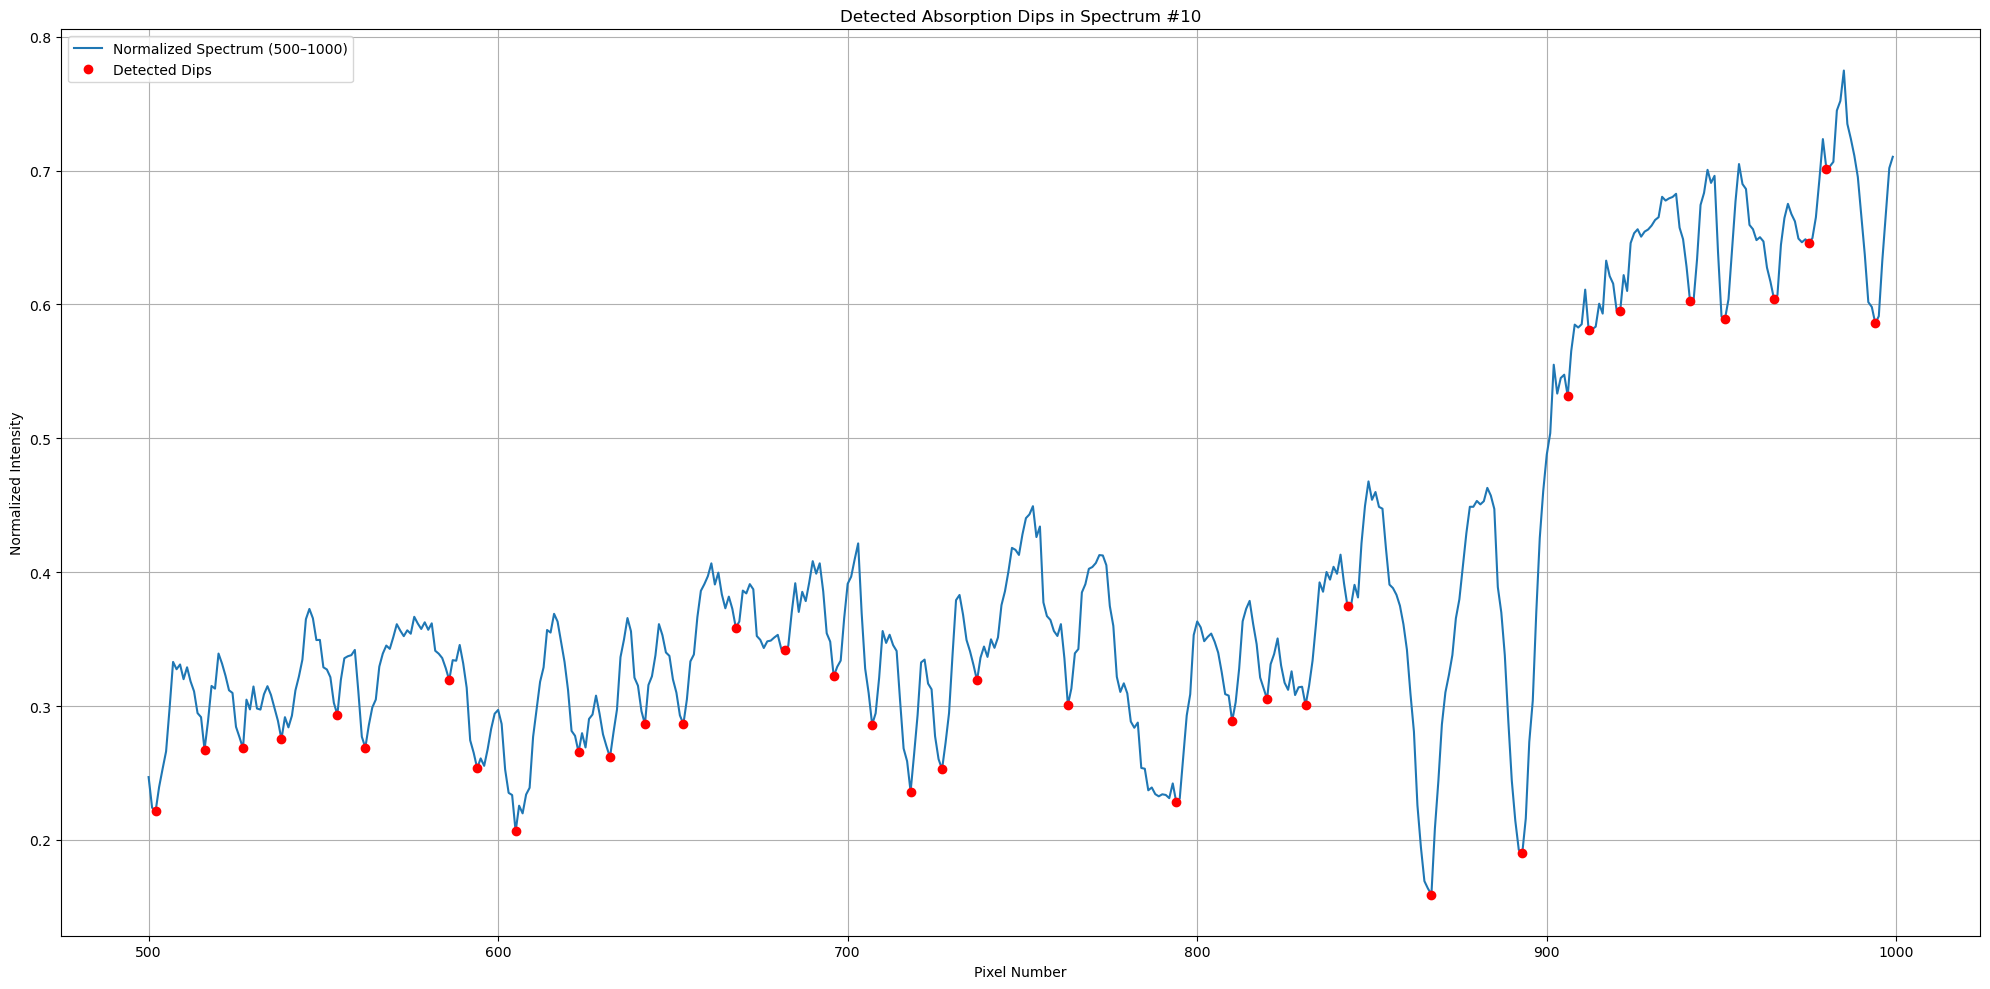


Detected dips in spectrum #10 (Pixels 500–1000):

Dip 1: Pixel = 502, FWHM = 2.15 pixels
Dip 2: Pixel = 516, FWHM = 3.77 pixels
Dip 3: Pixel = 527, FWHM = 3.74 pixels
Dip 4: Pixel = 538, FWHM = 4.74 pixels
Dip 5: Pixel = 554, FWHM = 2.73 pixels
Dip 6: Pixel = 562, FWHM = 5.75 pixels
Dip 7: Pixel = 586, FWHM = 2.44 pixels
Dip 8: Pixel = 594, FWHM = 5.52 pixels
Dip 9: Pixel = 605, FWHM = 9.87 pixels
Dip 10: Pixel = 623, FWHM = 5.00 pixels
Dip 11: Pixel = 632, FWHM = 14.62 pixels
Dip 12: Pixel = 642, FWHM = 5.39 pixels
Dip 13: Pixel = 653, FWHM = 4.89 pixels
Dip 14: Pixel = 668, FWHM = 2.74 pixels
Dip 15: Pixel = 682, FWHM = 10.82 pixels
Dip 16: Pixel = 696, FWHM = 5.33 pixels
Dip 17: Pixel = 707, FWHM = 3.63 pixels
Dip 18: Pixel = 718, FWHM = 6.57 pixels
Dip 19: Pixel = 727, FWHM = 4.42 pixels
Dip 20: Pixel = 737, FWHM = 9.06 pixels
Dip 21: Pixel = 763, FWHM = 5.16 pixels
Dip 22: Pixel = 794, FWHM = 22.12 pixels
Dip 23: Pixel = 810, FWHM = 4.96 pixels
Dip 24: Pixel = 820, FWHM = 3.13 pi

In [191]:
from scipy.signal import find_peaks, peak_widths
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Normalize each spectrum
ss_l0_normalized = np.array([s / np.max(s) for s in ss_l0])

# Set which spectrum to inspect (change this value to explore other routines)
spectrum_index_to_plot = 10

# Define window and prominence
start = 500
end = 1000
prominence_threshold = 0.02

# Get selected spectrum and inverted version
spectrum = ss_l0_normalized[spectrum_index_to_plot]
inverted_segment = -spectrum[start:end]

# Find dips in this window
peaks, properties = find_peaks(inverted_segment, prominence=prominence_threshold, distance=5)

# Get FWHM of dips
results_half = peak_widths(inverted_segment, peaks, rel_height=0.5)
fwhm_pixels = results_half[0]  # FWHM in pixels

# Convert local peak positions to global pixel numbers
dip_pixels_global = peaks + start

# Plot
plt.figure(figsize=(20, 10))
plt.plot(np.arange(start, end), spectrum[start:end], label='Normalized Spectrum (500–1000)')
plt.plot(dip_pixels_global, spectrum[dip_pixels_global], 'ro', label='Detected Dips')
plt.title(f'Detected Absorption Dips in Spectrum #{spectrum_index_to_plot}')
plt.xlabel("Pixel Number")
plt.ylabel("Normalized Intensity")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Print results
print(f"\nDetected dips in spectrum #{spectrum_index_to_plot} (Pixels {start}–{end}):\n")
for i, (pix, width) in enumerate(zip(dip_pixels_global, fwhm_pixels)):
    print(f"Dip {i+1}: Pixel = {pix}, FWHM = {width:.2f} pixels")


In [235]:
from scipy.signal import find_peaks, peak_widths
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Normalize and trim spectra: remove first 10 and last 5
ss_l0_normalized = np.array([s / np.max(s) for s in ss_l0])
ss_trimmed = ss_l0_normalized[:]

# Window settings
start = 1000
end = 1500
prominence_threshold = 0.2

print(f"Analyzing {len(ss_trimmed)} spectra from index 5 to {len(ss_l0) - 6} (inclusive)\n")

# Loop through each spectrum and print dips
for i, spectrum in enumerate(ss_trimmed):
    spectrum_index = i + 0  # original index in ss_l0
    inverted_segment = -spectrum[start:end]

    # Detect dips
    peaks, properties = find_peaks(inverted_segment, prominence=prominence_threshold, distance=5)
    results_half = peak_widths(inverted_segment, peaks, rel_height=0.5)
    fwhm_pixels = results_half[0]
    dip_pixels_global = peaks + start

    # Print result
    print(f"Spectrum #{spectrum_index}:")
    if len(dip_pixels_global) == 0:
        print("  No dips detected.")
    else:
        for j, (pix, width) in enumerate(zip(dip_pixels_global, fwhm_pixels)):
            print(f"  Dip {j+1}: Pixel = {pix}, FWHM = {width:.2f} pixels")
    print('-' * 50)


Analyzing 75 spectra from index 5 to 69 (inclusive)

Spectrum #0:
  No dips detected.
--------------------------------------------------
Spectrum #1:
  No dips detected.
--------------------------------------------------
Spectrum #2:
  Dip 1: Pixel = 1154, FWHM = 13.80 pixels
--------------------------------------------------
Spectrum #3:
  Dip 1: Pixel = 1154, FWHM = 22.09 pixels
--------------------------------------------------
Spectrum #4:
  No dips detected.
--------------------------------------------------
Spectrum #5:
  Dip 1: Pixel = 1153, FWHM = 13.66 pixels
--------------------------------------------------
Spectrum #6:
  Dip 1: Pixel = 1154, FWHM = 14.25 pixels
--------------------------------------------------
Spectrum #7:
  Dip 1: Pixel = 1154, FWHM = 15.11 pixels
--------------------------------------------------
Spectrum #8:
  Dip 1: Pixel = 1154, FWHM = 14.82 pixels
--------------------------------------------------
Spectrum #9:
  Dip 1: Pixel = 1154, FWHM = 17.16 pixe

(75, 2048)


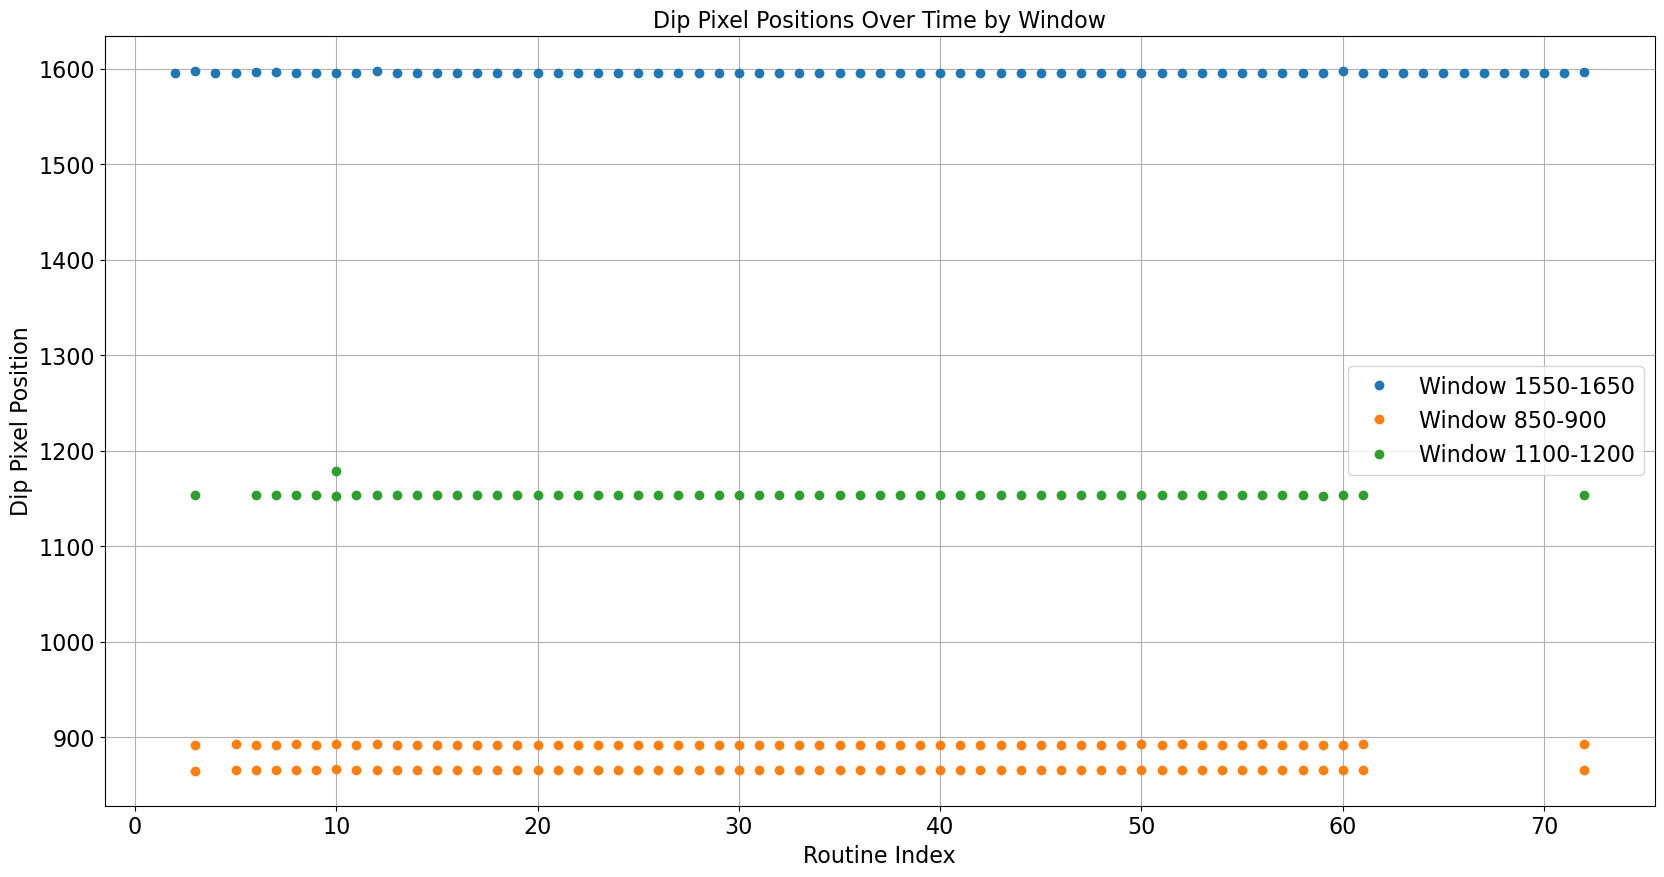

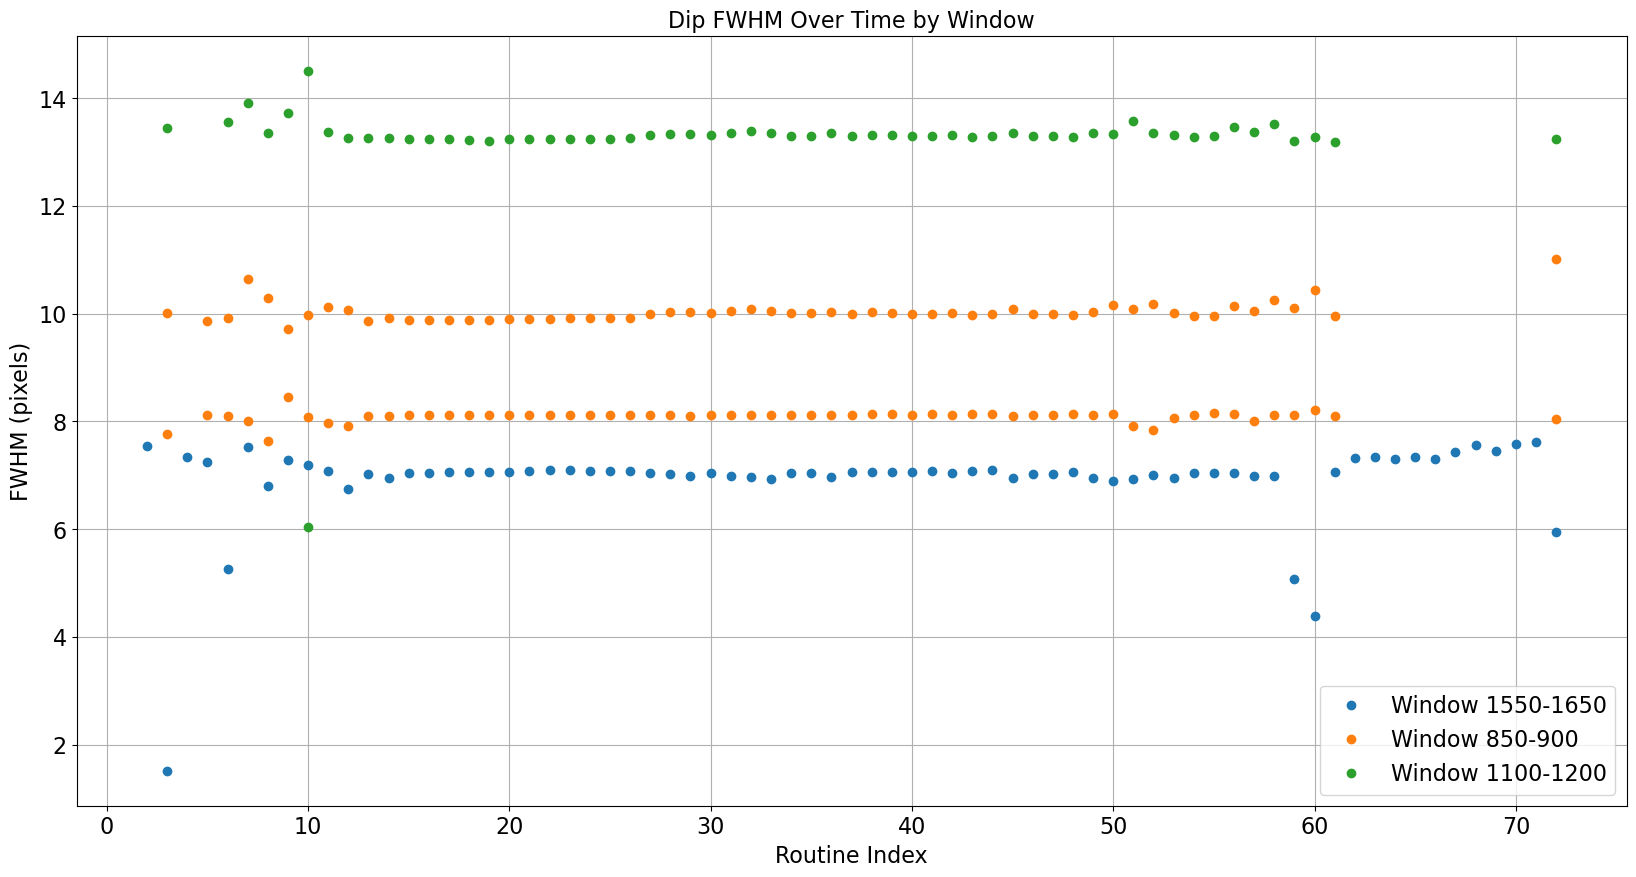

In [331]:
from scipy.signal import find_peaks, peak_widths
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Normalize all spectra
ss_l0_normalized = np.array([s / np.max(s) for s in sq_l0])
print(ss_l0_normalized.shape)

# Pixel ranges and corresponding prominence thresholds
window_settings = [
    {'start': 850, 'end': 900, 'prominence': 0.17},
    {'start': 1100, 'end': 1200, 'prominence': 0.21},
    {'start': 1550, 'end': 1650, 'prominence': 0.2}
]

# Data storage
dip_tracking = {
    'routine': [],
    'window': [],
    'dip_pixel': [],
    'fwhm': []
}

# Loop through each spectrum
for i, spectrum in enumerate(ss_l0_normalized):
    inverted = -spectrum  # for dip detection
    for win_idx, win in enumerate(window_settings):
        start, end = win['start'], win['end']
        segment = inverted[start:end]
        
        # Find dips in this window
        peaks, props = find_peaks(segment, prominence=win['prominence'], distance=5)
        widths = peak_widths(segment, peaks, rel_height=0.5)[0]

        # Record dip pixel and FWHM (adjusted to global pixel number)
        for p, w in zip(peaks, widths):
            dip_tracking['routine'].append(i)
            dip_tracking['window'].append(f"{start}-{end}")
            dip_tracking['dip_pixel'].append(p + start)
            dip_tracking['fwhm'].append(w)

# Convert to DataFrame
dip_df = pd.DataFrame(dip_tracking)

# Example: visualize one window’s dip pixels over time
plt.figure(figsize=(20, 10))
for win in dip_df['window'].unique():
    subset = dip_df[dip_df['window'] == win]
    plt.plot(subset['routine'], subset['dip_pixel'], 'o', label=f'Window {win}')
plt.xlabel('Routine Index',fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylabel('Dip Pixel Position', fontsize=16)
# plt.ylim(775,900)
plt.title('Dip Pixel Positions Over Time by Window', fontsize=16)
plt.legend(fontsize=16)
plt.grid(True)
plt.show()

# Plot FWHM variation over time for each window
plt.figure(figsize=(20, 10))
# plt.yscale('log')
for win in dip_df['window'].unique():
    subset = dip_df[dip_df['window'] == win]
    plt.plot(subset['routine'], subset['fwhm'], 'o', label=f'Window {win}')
    
plt.xlabel('Routine Index', fontsize=16)
plt.ylabel('FWHM (pixels)', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
# plt.ylim(0,15)
plt.title('Dip FWHM Over Time by Window', fontsize=16)
plt.legend(fontsize=16)
plt.grid(True)
plt.show()

In [327]:
print(dip_df['window'])

0      1550-1650
1        850-900
2        850-900
3      1100-1200
4      1550-1650
         ...    
243    1550-1650
244      850-900
245      850-900
246    1100-1200
247    1550-1650
Name: window, Length: 248, dtype: object


(75, 2048)


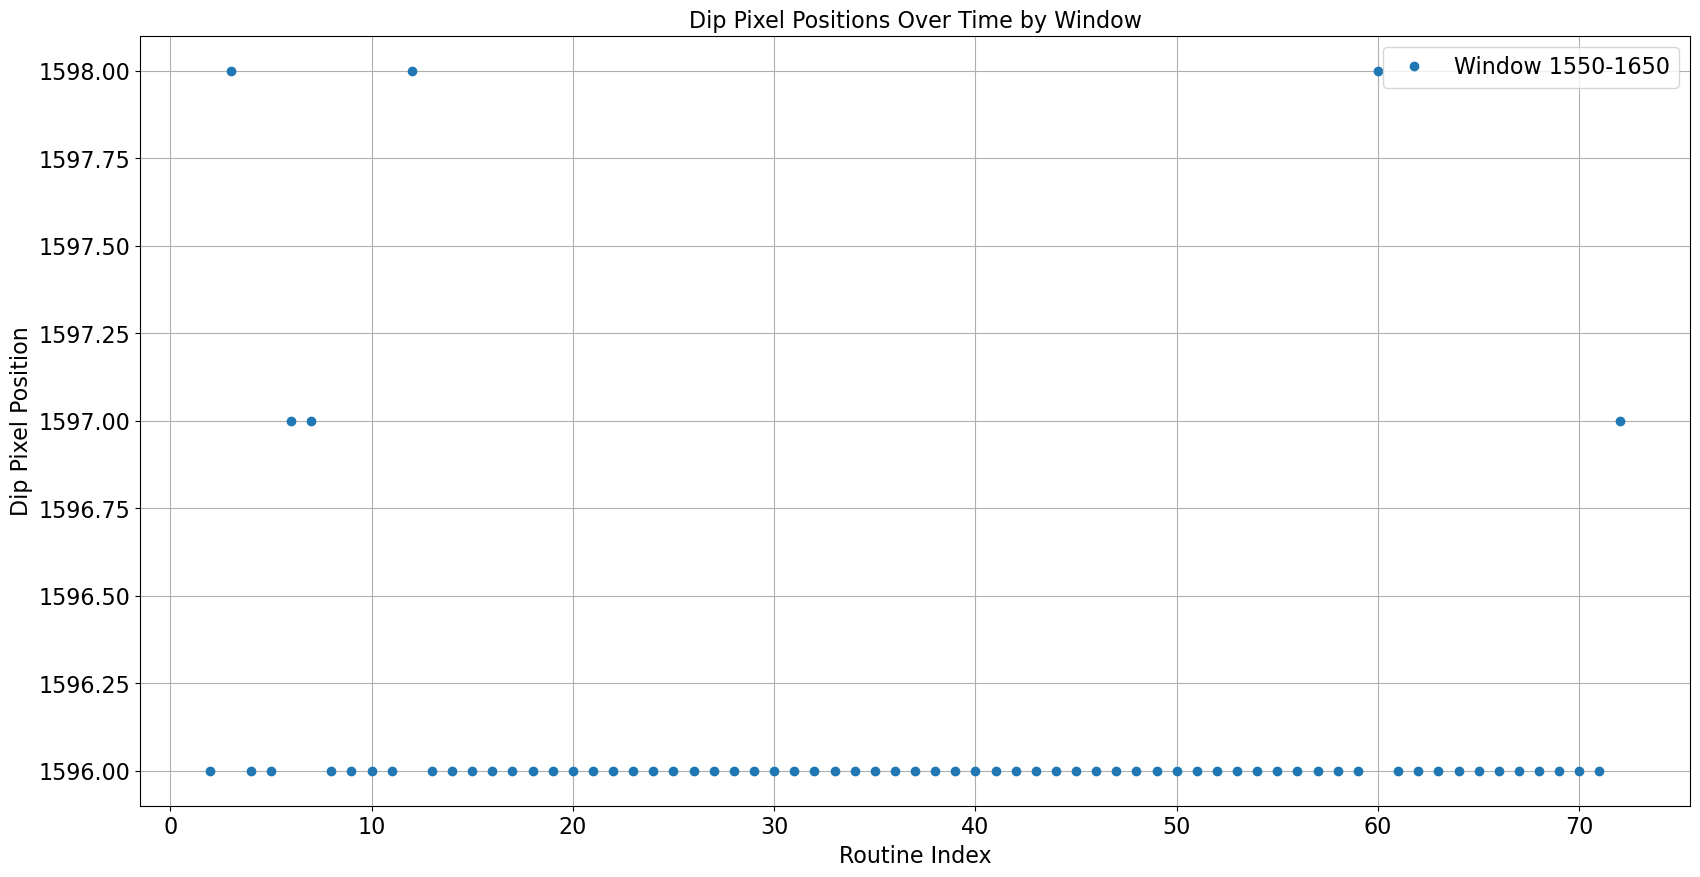

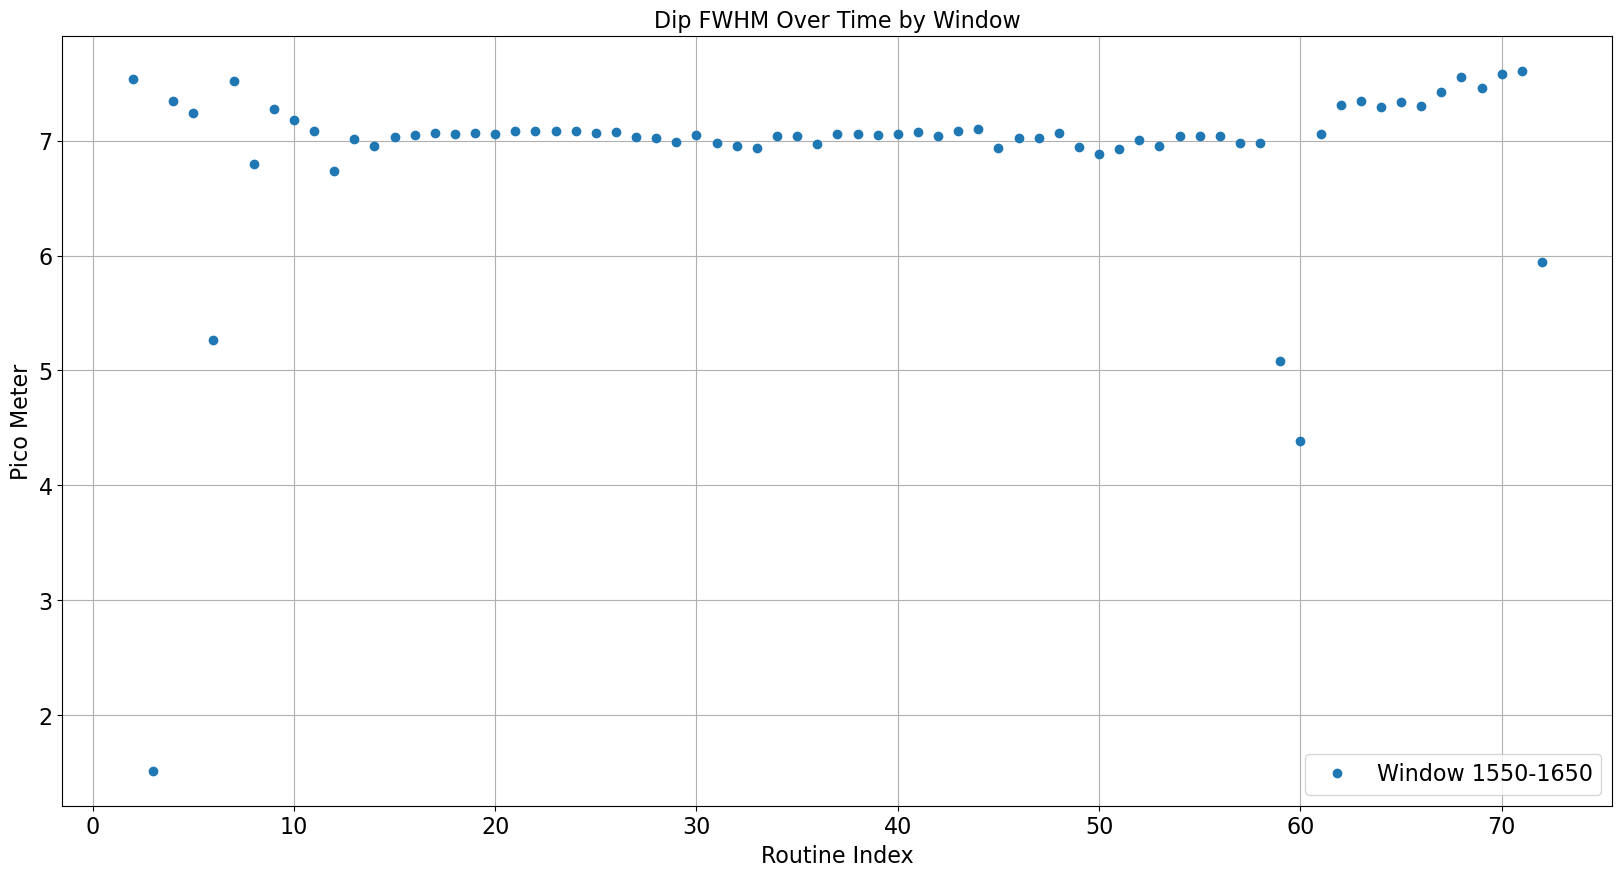

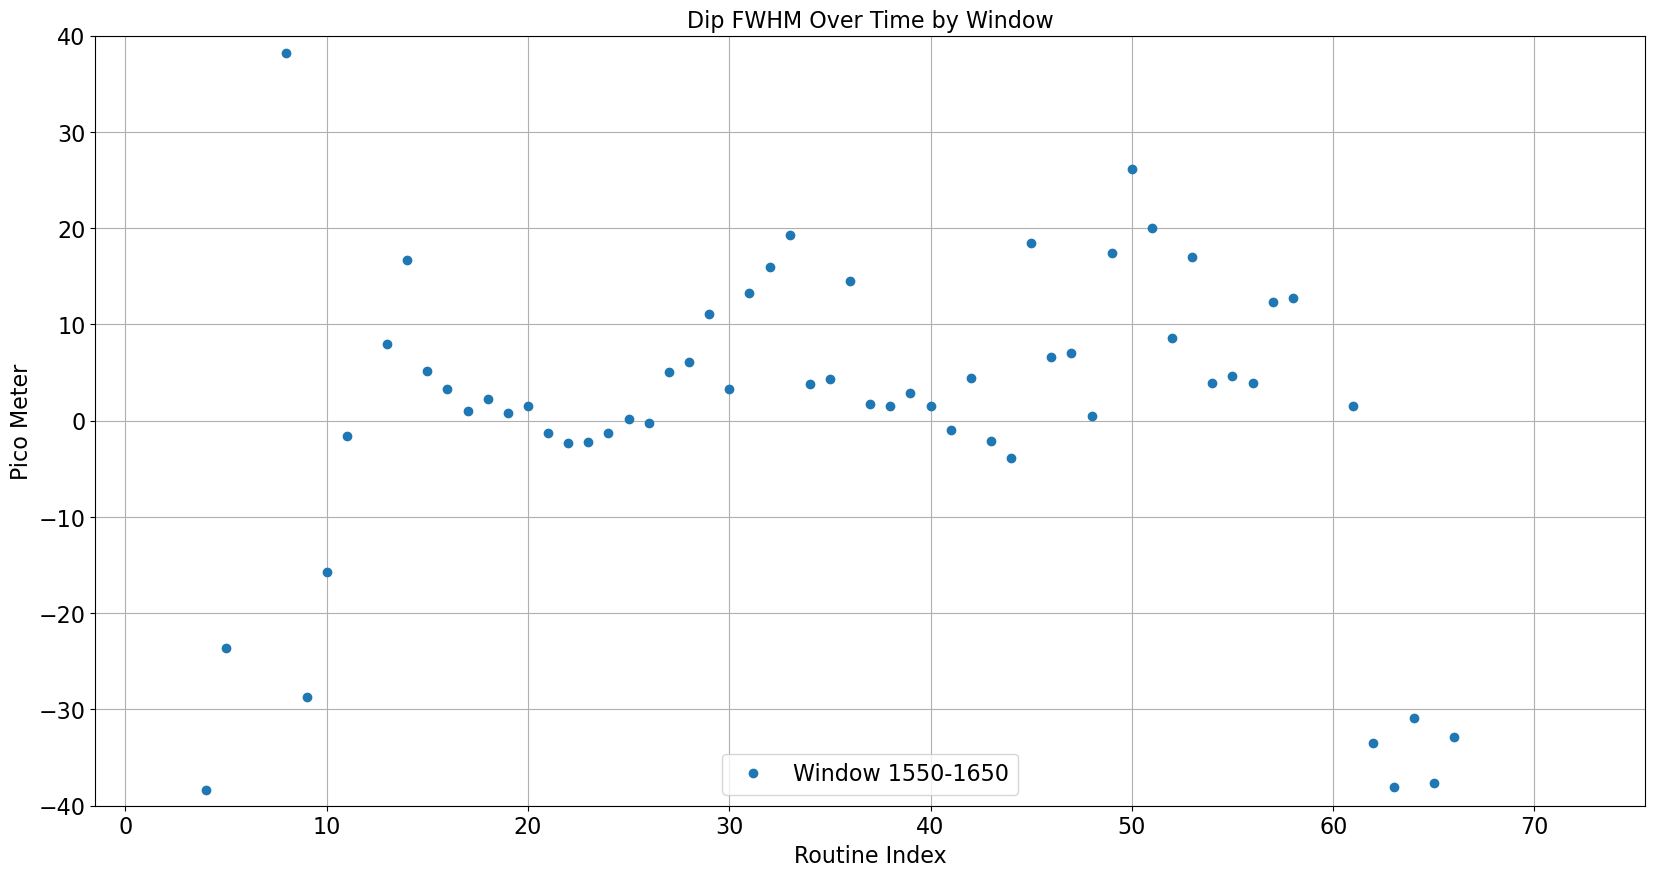

In [351]:
from scipy.signal import find_peaks, peak_widths
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Normalize all spectra
ss_l0_normalized = np.array([s / np.max(s) for s in sq_l0])
print(ss_l0_normalized.shape)

# Pixel ranges and corresponding prominence thresholds
window_settings = [
    {'start': 1550, 'end': 1650, 'prominence': 0.2}
]

# Data storage
dip_tracking = {
    'routine': [],
    'window': [],
    'dip_pixel': [],
    'fwhm': []
}

# Loop through each spectrum
for i, spectrum in enumerate(ss_l0_normalized):
    inverted = -spectrum  # for dip detection
    for win_idx, win in enumerate(window_settings):
        start, end = win['start'], win['end']
        segment = inverted[start:end]
        
        # Find dips in this window
        peaks, props = find_peaks(segment, prominence=win['prominence'], distance=5)
        widths = peak_widths(segment, peaks, rel_height=0.5)[0]

        # Record dip pixel and FWHM (adjusted to global pixel number)
        for p, w in zip(peaks, widths):
            dip_tracking['routine'].append(i)
            dip_tracking['window'].append(f"{start}-{end}")
            dip_tracking['dip_pixel'].append(p + start)
            dip_tracking['fwhm'].append(w)

# Convert to DataFrame
dip_df = pd.DataFrame(dip_tracking)

# Example: visualize one window’s dip pixels over time
plt.figure(figsize=(20, 10))
for win in dip_df['window'].unique():
    subset = dip_df[dip_df['window'] == win]
    plt.plot(subset['routine'], subset['dip_pixel'], 'o', label=f'Window {win}')
plt.xlabel('Routine Index',fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylabel('Dip Pixel Position', fontsize=16)
# plt.ylim(775,900)
plt.title('Dip Pixel Positions Over Time by Window', fontsize=16)
plt.legend(fontsize=16)
plt.grid(True)
plt.show()

# Plot FWHM variation over time for each window
plt.figure(figsize=(20, 10))
# plt.yscale('log')
for win in dip_df['window'].unique():
    subset = dip_df[dip_df['window'] == win]
    plt.plot(subset['routine'], subset['fwhm'], 'o', label=f'Window {win}')
    
plt.xlabel('Routine Index', fontsize=16)
plt.ylabel('Pico Meter', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
# plt.ylim(-40,40)
plt.title('Dip FWHM Over Time by Window', fontsize=16)
plt.legend(fontsize=16)
plt.grid(True)
plt.show()

# Plot FWHM variation over time for each window
plt.figure(figsize=(20, 10))
# plt.yscale('log')
for win in dip_df['window'].unique():
    subset = dip_df[dip_df['window'] == win]
    plt.plot(subset['routine'], 990- (subset['fwhm']*140), 'o', label=f'Window {win}')
    
plt.xlabel('Routine Index', fontsize=16)
plt.ylabel('Pico Meter', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylim(-40,40)
plt.title('Dip FWHM Over Time by Window', fontsize=16)
plt.legend(fontsize=16)
plt.grid(True)
plt.show()

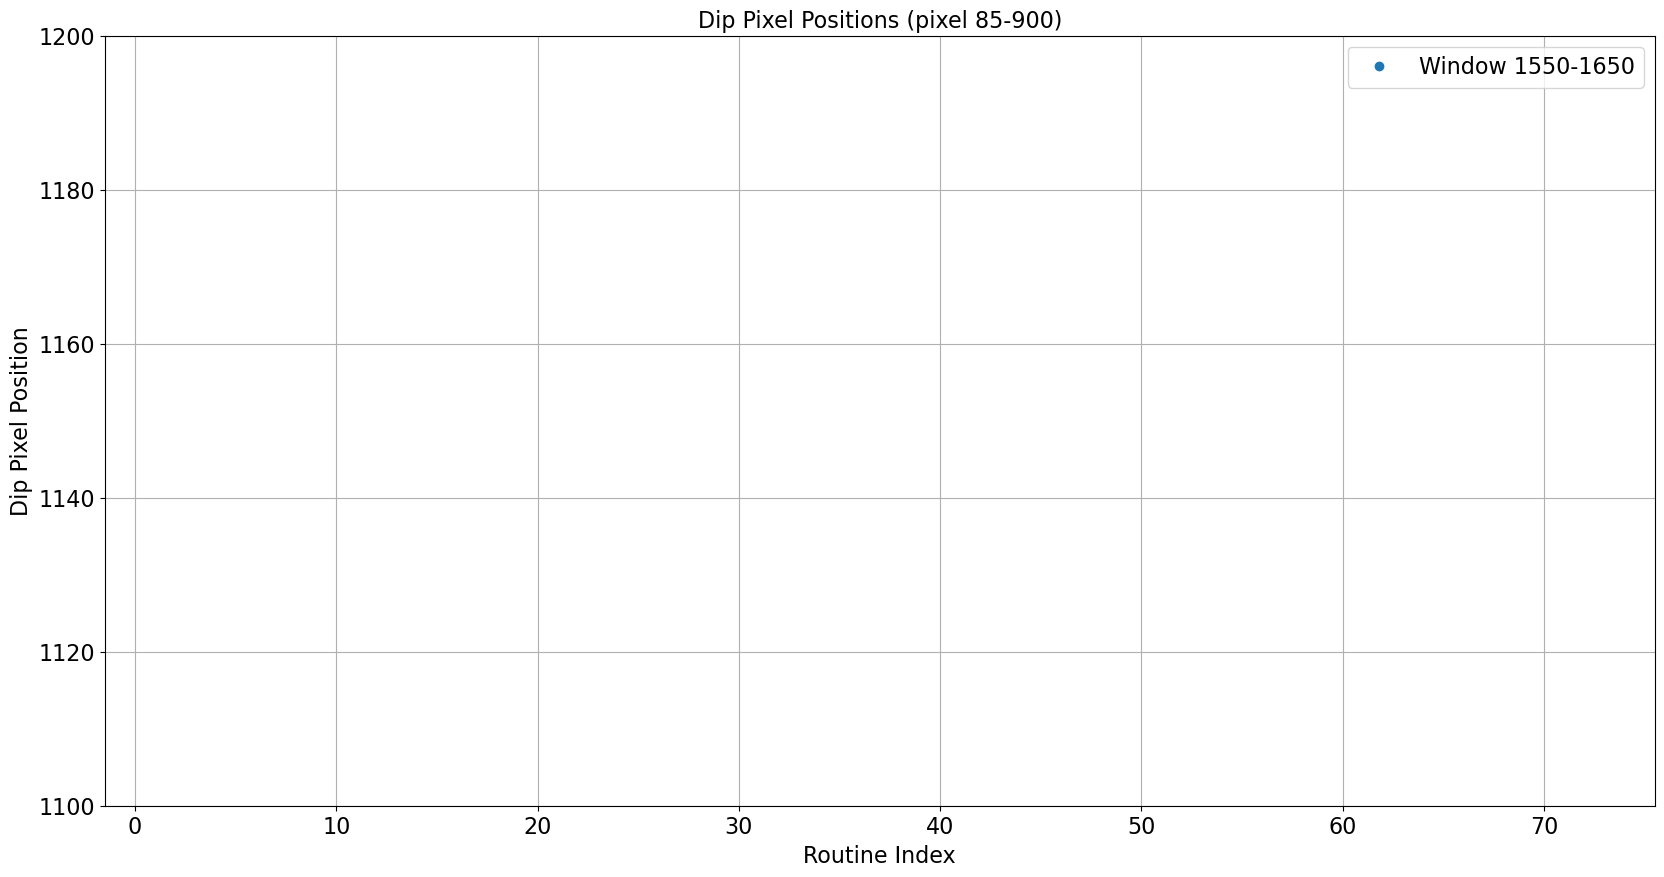

In [348]:
plt.figure(figsize=(20, 10))
for win in dip_df['window'].unique():
    subset = dip_df[dip_df['window'] == win]
    plt.plot(subset['routine'], subset['dip_pixel'], 'o', label=f'Window {win}')
plt.xlabel('Routine Index',fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylabel('Dip Pixel Position', fontsize=16)
plt.ylim(1100,1200)
plt.title('Dip Pixel Positions (pixel 85-900)', fontsize=16)
plt.legend(fontsize=16)
plt.grid(True)
plt.show()

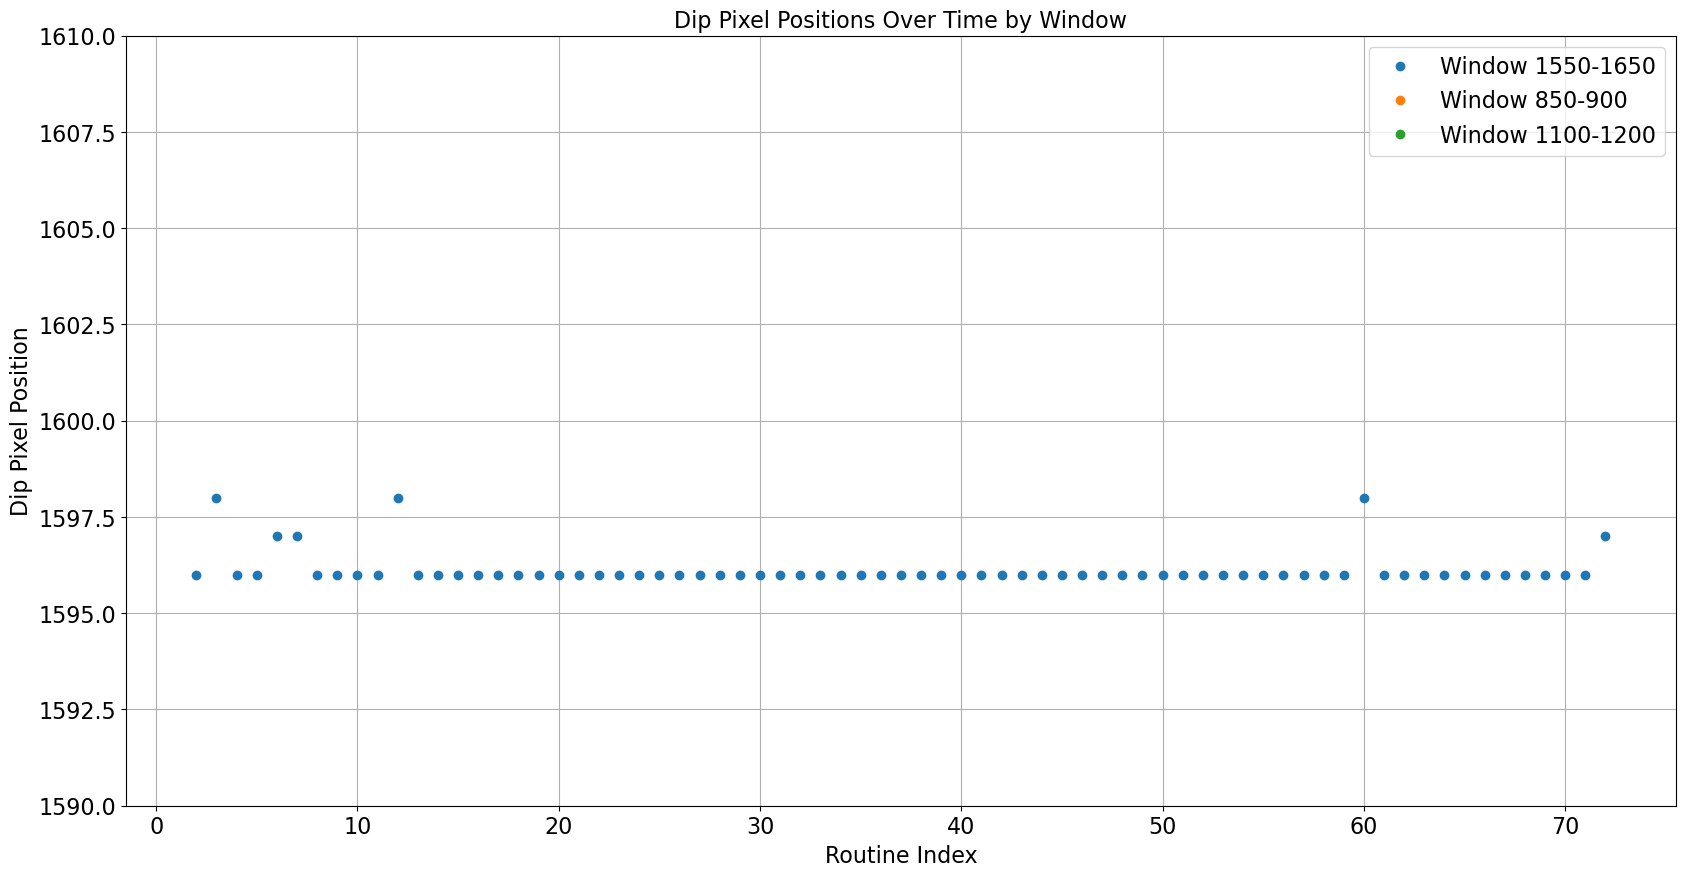

In [317]:
plt.figure(figsize=(20, 10))
for win in dip_df['window'].unique():
    subset = dip_df[dip_df['window'] == win]
    plt.plot(subset['routine'], subset['dip_pixel'], 'o', label=f'Window {win}')
plt.xlabel('Routine Index',fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylabel('Dip Pixel Position', fontsize=16)
plt.ylim(1590,1610)
plt.title('Dip Pixel Positions Over Time by Window', fontsize=16)
plt.legend(fontsize=16)
plt.grid(True)
plt.show()

In [101]:
import numpy as np
np.set_printoptions(threshold = np.inf)
print(calibrated_wavelengths)

[532.7809 532.7809 532.7809 532.7809 532.7809 532.7809 532.7809 532.7809
 532.7809 532.7809 532.7809 532.7809 532.7809 532.7809 532.7809 532.7809
 532.7809 532.7809 532.7809 532.7809 532.7809 532.7809 532.7809 532.7809
 532.7809 532.7809 532.7809 532.7809 532.7809 532.7809 532.7809 532.7809
 532.7809 532.7809 532.7809 532.7809 532.7809 532.7809 532.7809 532.7809
 532.7809 532.7809 532.7809 532.7809 532.7809 532.7809 532.7809 532.7809
 532.7809 532.7809 532.7809 532.7809 532.7809 532.7809 532.7809 532.7809
 532.7809 532.7809 532.7809 532.7809 532.7809 532.7809 532.7809 532.7809
 532.7809 532.7809 532.7809 532.7809 532.7809 532.7809 532.7809 532.7809
 532.7809 532.7809 532.7809 532.7809 532.7809 532.7809 532.7809 532.7809
 532.7809 532.7809 532.7809 532.7809 532.7809 532.7809 532.7809 532.7809
 532.7809 532.7809 532.7809 532.7809 532.7809 532.7809 532.7809 532.7809
 532.7809 532.7809 532.7809 532.7809 532.7809 532.7809 532.7809 532.7809
 532.7809 532.7809 532.7809 532.7809 532.7809 532.7